## Домашнее задание №6

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров. 

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [64]:
X, y = load_diabetes(return_X_y=True)

In [65]:
X_, X_test, y_, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [66]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_, y_, test_size=0.25)

In [67]:
X_train.shape, X_valid.shape, X_test.shape

((248, 10), (83, 10), (111, 10))

In [68]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [69]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [70]:
def bias(y, z):
    return (y - z)

In [71]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [72]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):


    test_prediction = gb_predict(X_test, trees, coefs, eta)

#     print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
#     с шагом {eta} на валидационной выборке: {mean_squared_error(y_test, test_prediction)}')
    
    return mean_squared_error(y_test, test_prediction)

In [73]:
# Число деревьев в ансамбле
n_trees_list = [3, 5, 10, 20, 30]

# Максимальная глубина деревьев
max_depth_list = np.arange(1, 10)

# Шаг
eta = 1

errors = {}

In [74]:
for n_trees in n_trees_list:
    
    errors[f'n_trees_{n_trees}'] = {}

    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_trees

    for max_depth in max_depth_list:
        trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_valid, y_train, y_valid, coefs, eta)
        
        errors[f'n_trees_{n_trees}'][max_depth] = evaluate_alg(X_train, X_valid, y_train, y_valid, trees, coefs, eta)

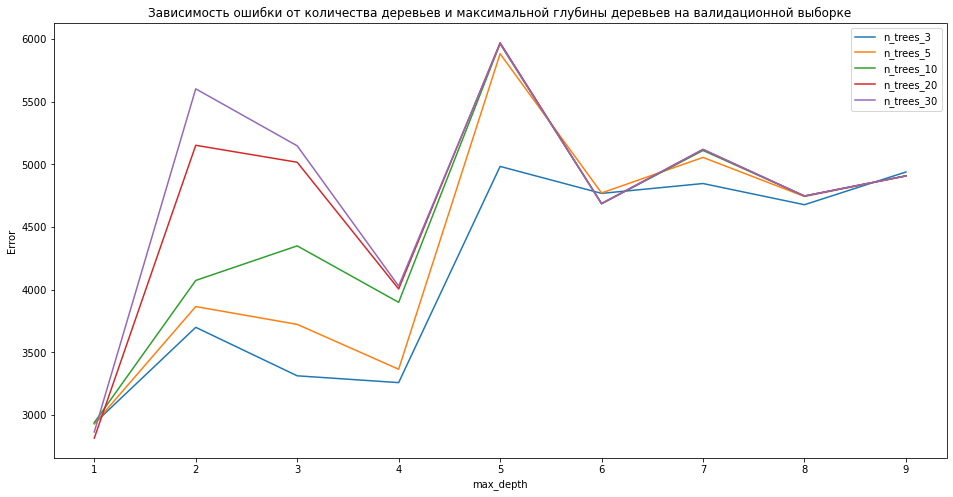

In [75]:
plt.figure(figsize=(16, 8))
for k, v in errors.items():
    plt.plot(errors[k].keys(), errors[k].values(), label = str(k))
plt.legend()
plt.title('Зависимость ошибки от количества деревьев и максимальной глубины деревьев на валидационной выборке')
plt.xlabel('max_depth')
plt.ylabel('Error')
plt.show()

Таким образом, на валидационном датасете видно, что наилучший результат показывают очень короткие деревья с их количеством не менее 5, причём нельзя сказать, что результаты моделей с числом деревьев от 5 до 30 при глубине дерева 1 разительно отличаются. Проверим вывод на тестовой выборке.

In [76]:
errors_test = {}

for n_trees in n_trees_list:
    
    errors_test[f'n_trees_{n_trees}'] = {}

    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_trees

    for max_depth in max_depth_list:
        trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        
        errors_test[f'n_trees_{n_trees}'][max_depth] = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

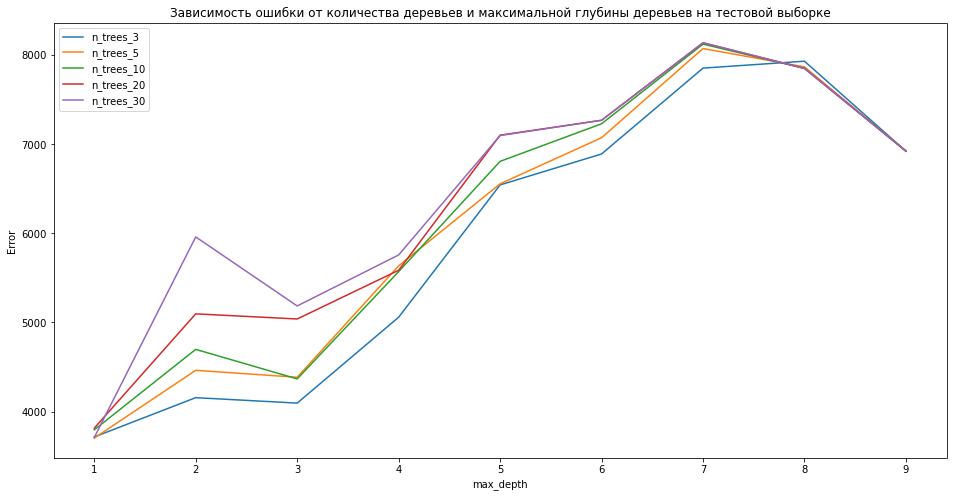

In [77]:
plt.figure(figsize=(16, 8))
for k, v in errors_test.items():
    plt.plot(errors_test[k].keys(), errors_test[k].values(), label = str(k))
plt.legend()
plt.title('Зависимость ошибки от количества деревьев и максимальной глубины деревьев на тестовой выборке')
plt.xlabel('max_depth')
plt.ylabel('Error')
plt.show()

На тестовом датасете вывод подтвердился.

2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [78]:
def gb_st_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, size=0.5):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # Определяем случайные индексы
        idx = set()
        while len(idx) < len(X_train) * size:
            idx.add(np.random.randint(len(X_train)))
        idx = list(idx)
        
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[idx], y_train[idx])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[idx], bias(y_train[idx], target[idx]))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [91]:
n_trees = 20
max_depth = 1
eta = 1
coefs = [1]*n_trees

trees_st, train_errors_st, test_errors_st = gb_st_fit(n_trees, max_depth, X_train, X_test, 
                                                       y_train, y_test, coefs, eta)
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, 
                                                       y_train, y_test, coefs, eta)


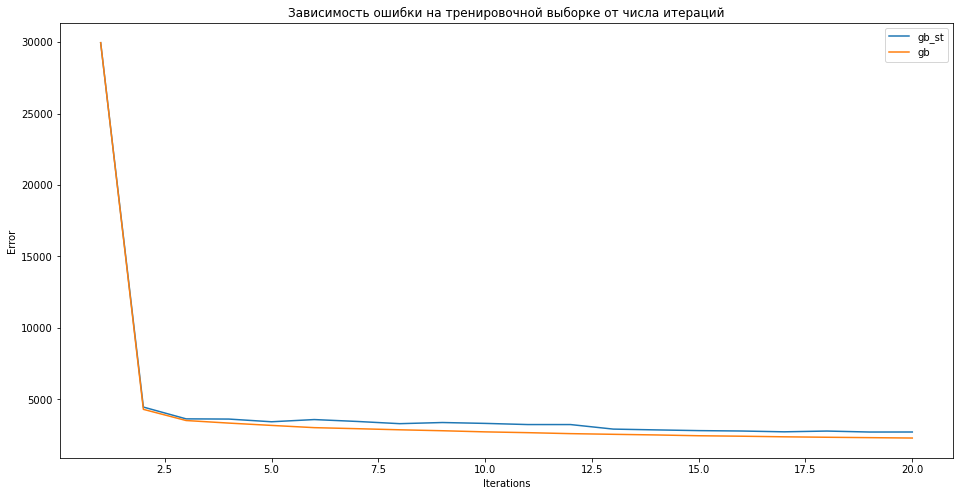

In [96]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1, len(train_errors_st)+1), train_errors_st, label = 'gb_st')
plt.plot(np.arange(1, len(train_errors)+1), train_errors, label = 'gb')
plt.legend()
plt.title('Зависимость ошибки на тренировочной выборке от числа итераций')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

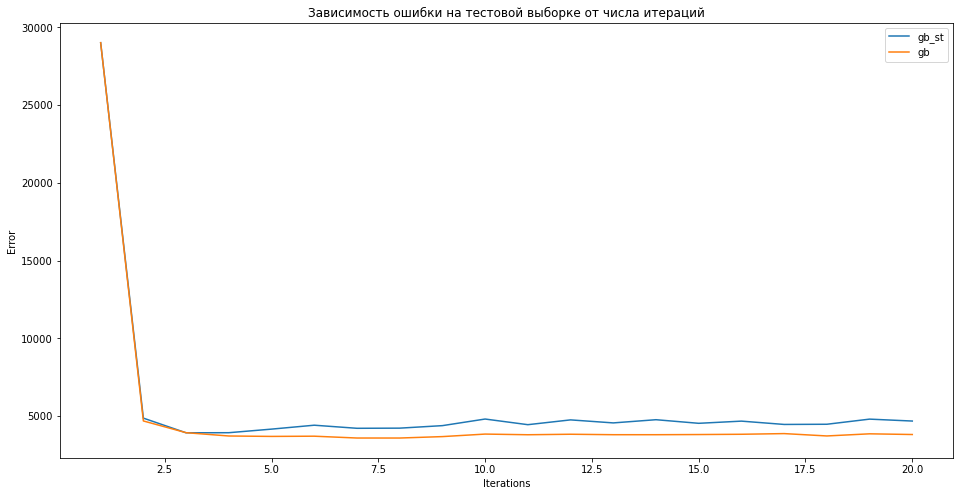

In [97]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(1, len(test_errors_st)+1), test_errors_st, label = 'gb_st')
plt.plot(np.arange(1, len(test_errors)+1), test_errors, label = 'gb')
plt.legend()
plt.title('Зависимость ошибки на тестовой выборке от числа итераций')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()

Как видно из графиков, стохастический градиентный бустинг сходится немного медленнее и показывает несколько большую ошибку на тестовой выборке, но при этом тратит практически в 2 раза меньше ресурсов.